In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install catboost

## Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data/ml-3-autos.csv')

In [ ]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [ ]:
df.drop(['DateCrawled','DateCreated','PostalCode','LastSeen', 'RegistrationMonth','NumberOfPictures'], axis = 1
        , inplace = True)

Дропаю бесполезные столбцы.

In [ ]:
df.isna().mean()

Price               0.000000
VehicleType         0.105794
RegistrationYear    0.000000
Gearbox             0.055967
Power               0.000000
Model               0.055606
Kilometer           0.000000
FuelType            0.092827
Brand               0.000000
NotRepaired         0.200791
dtype: float64

In [ ]:
df.columns = df.columns.str.lower()

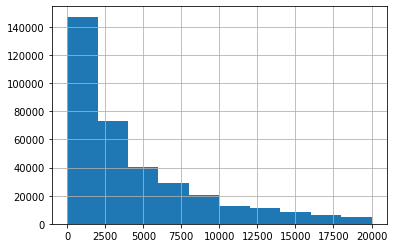

In [ ]:
df['price'].hist()

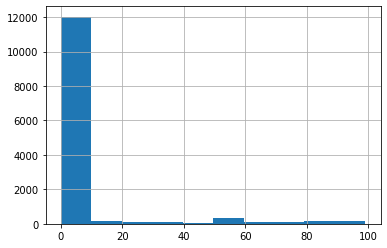

In [ ]:
df[df['price'] < 100]['price'].hist()

Много значений с низкой ценой, скорее всего какая-то аномалия. Удаляю.

In [ ]:
df = df[df['price'] > 100].copy()

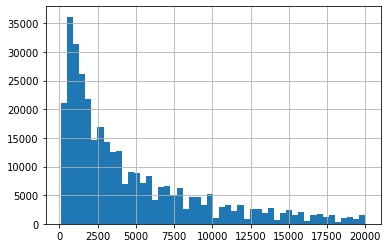

In [ ]:
df['price'].hist(bins = 50)

In [ ]:
df.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [ ]:
for col in df:
    print(col)
    print(df[col].unique())
    print()

price
[  480 18300  9800 ... 12395 18429 10985]

vehicletype
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

registrationyear
[1993 2011 2004 2001 2008 1995 2014 1998 2005 1910 2016 2007 2009 2002
 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010 2000
 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1969 1971 1987 1986
 1988 1980 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977 1961
 1966 1975 1963 1964 1960 1958 1967 1956 3200 1000 1941 9999 8888 1500
 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019 1937 1951 1800 1959
 1953 1954 1234 5300 9000 2900 6000 5900 5911 1400 5000 1950 4000 1948
 1952 8500 1932 3700 3800 4800 1942 7000 1935 1933 1936 1923 2290 1930
 1001 9450 1944 2500 1943 1938 1934 1928 5555 5600 1600 1111 1039 1300
 2800 1931 4500 1602 7800 1947 1927 7100 8200 1946]

gearbox
['manual' 'auto' nan]

power
[    0   190   163    75    69   102   109   125   101   105   140   115
   131    60   136   160   231    90    50   11

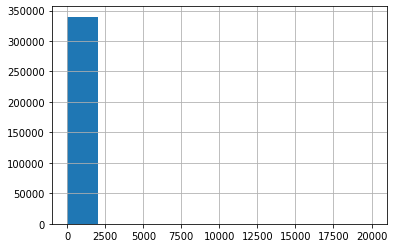

In [ ]:
df['power'].hist()

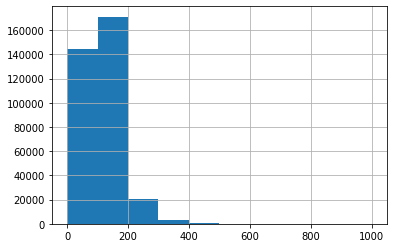

In [ ]:
df[df['power']< 1000]['power'].hist()

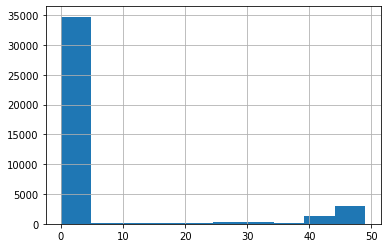

In [ ]:
df[df['power'] < 50]['power'].hist()

Так как автомобили со значением лошадиной силы более 800 и менее 40 встретить довольно сложно, удаляю аномалии.

In [ ]:
df = df[df['power'] < 800].copy()

In [ ]:
df = df[df['power'] > 40].copy()

In [ ]:
df['vehicletype'].fillna('other', inplace = True)

In [ ]:
df['fueltype'].fillna('other', inplace = True)

In [ ]:
df['brand'].fillna('other', inplace = True)

Отправляю пропуски, где это возможно, в категорию 'другие'.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303434 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             303434 non-null  int64 
 1   vehicletype       303434 non-null  object
 2   registrationyear  303434 non-null  int64 
 3   gearbox           297638 non-null  object
 4   power             303434 non-null  int64 
 5   model             291500 non-null  object
 6   kilometer         303434 non-null  int64 
 7   fueltype          303434 non-null  object
 8   brand             303434 non-null  object
 9   notrepaired       257483 non-null  object
dtypes: int64(4), object(6)
memory usage: 25.5+ MB


In [ ]:
for col in df:
    print(col)
    print(df[col].unique())
    print()

price
[18300  9800  1500 ... 12395 18429 10985]

vehicletype
['coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

registrationyear
[2011 2004 2001 2008 1995 2014 1998 2005 2016 2007 2009 2002 2018 1997
 1990 2017 1981 2003 1991 1984 2006 1999 2012 2010 2000 1992 2013 1994
 1996 1989 2015 1993 1985 1982 1983 1973 1969 1971 1987 1988 1980 1986
 1976 1965 1945 1974 1978 1979 1972 1977 1961 1975 1970 1968 1963 1966
 1958 1941 1500 1960 1910 1967 1949 1959 1953 1964 2019 1962 2900 6000
 5911 4000 1955 1956 1951 1950 5000 1942 1957 9999 1954 1952 1943 1800
 2800 1000 1948 4500 1937 8200 1947]

gearbox
['manual' 'auto' nan]

power
[190 163  75  69 102 109 125 101 105 140 115 131  60 136 160 231  90  50
 118 193  99 113 218 122 129  70 306  95  61 177  80 170  55 143  64 232
 150 156  82 155  54 185  87 180  86  84 224 235 200 178 265  77 110 144
 120 286 116 184 126 204  88 194 305 197 179 250  45 313  41 165  98 130
 114 211  56 201 213  58 107  83 174 100 220  85  73 192  68

In [ ]:
df.isna().mean()

price               0.000000
vehicletype         0.000000
registrationyear    0.000000
gearbox             0.019101
power               0.000000
model               0.039330
kilometer           0.000000
fueltype            0.000000
brand               0.000000
notrepaired         0.151437
dtype: float64

In [ ]:
df.dropna(inplace = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246823 entries, 3 to 354367
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             246823 non-null  int64 
 1   vehicletype       246823 non-null  object
 2   registrationyear  246823 non-null  int64 
 3   gearbox           246823 non-null  object
 4   power             246823 non-null  int64 
 5   model             246823 non-null  object
 6   kilometer         246823 non-null  int64 
 7   fueltype          246823 non-null  object
 8   brand             246823 non-null  object
 9   notrepaired       246823 non-null  object
dtypes: int64(4), object(6)
memory usage: 20.7+ MB


Дропаю пропуски, которые невозможно заполнить.

In [ ]:
base_df = df.copy()

In [ ]:
df = pd.get_dummies(df, drop_first = True)

In [ ]:
df.head()

,price,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_wagon,gearbox_manual,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_601,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_911,model_a1,model_a2,model_a3,...,fueltype_petrol,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,notrepaired_yes
3,1500,2001,75,150000,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,3600,2008,69,90000,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
5,650,1995,102,150000,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,2200,2004,109,150000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,2000,2004,105,150000,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
features = df.drop(['price'], axis = 1).copy()
target = df['price'].copy()

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(
features, target, test_size = 0.25, random_state = 4)

Разбиваю на 3 выборки: 75% треин, 25% тест.

Отобрал из необработанного дф фичи по индексам, совпадающим с битыми треин тест сплитом, чтобы все модели учились на одинаковых признаках.

In [ ]:
base_df

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
10,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no
...,...,...,...,...,...,...,...,...,...,...
354359,7900,sedan,2010,manual,140,golf,150000,gasoline,volkswagen,no
354361,5250,other,2016,auto,150,159,150000,other,alfa_romeo,no
354362,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no


In [ ]:
base_features = base_df.drop(['price'], axis = 1).copy()

In [ ]:
base_target = base_df['price'].copy()

In [ ]:
features_train2 = base_features[base_features.index.isin(features_train.index)]

In [ ]:
features_test2 = base_features[base_features.index.isin(features_test.index)]

In [ ]:
target_train2 = base_target[base_target.index.isin(target_train.index)]

In [ ]:
target_test2 = base_target[base_target.index.isin(target_test.index)]

In [ ]:
features_train2.columns

Index(['vehicletype', 'registrationyear', 'gearbox', 'power', 'model',
       'kilometer', 'fueltype', 'brand', 'notrepaired'],
      dtype='object')

In [ ]:
cat_features = ['vehicletype', 'gearbox', 'model',
       'fueltype', 'brand', 'notrepaired']

## Обучение моделей

In [ ]:
model = LinearRegression()

In [ ]:
time1 = time.time()
model.fit(features_train, target_train)
time2 = time.time()
LRfit = time2 - time1

In [ ]:
time1 = time.time()
predictions = model.predict(features_test)
time2 = time.time()
LRpred = time2 - time1

In [ ]:
LRscore = (mean_squared_error(target_test, predictions))**0.5

In [ ]:
LRfit, LRpred

(5.622779846191406, 0.12848687171936035)

In [ ]:
features_train3 = features_train2[cat_features].astype('category').copy()
features_test3 = features_test2[cat_features].astype('category').copy()

In [ ]:
features_train3.info(), features_test3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185117 entries, 3 to 354367
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   vehicletype  185117 non-null  category
 1   gearbox      185117 non-null  category
 2   model        185117 non-null  category
 3   fueltype     185117 non-null  category
 4   brand        185117 non-null  category
 5   notrepaired  185117 non-null  category
dtypes: category(6)
memory usage: 2.7 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 61706 entries, 19 to 354358
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   vehicletype  61706 non-null  category
 1   gearbox      61706 non-null  category
 2   model        61706 non-null  category
 3   fueltype     61706 non-null  category
 4   brand        61706 non-null  category
 5   notrepaired  61706 non-null  category
dtypes: category(6)
memory usage: 918.3 KB


(None, None)

In [ ]:
model = LGBMRegressor(random_state = 4)
grid = {'num_leaves': range(1,50),
        'n_estimators': range(10,150),
        'max_depth': range(1,100)}
random_search = RandomizedSearchCV(model, param_distributions = grid, n_iter = 10, random_state = 4
                                   , scoring = 'neg_mean_squared_error', n_jobs = - 1, cv = 5, verbose = 1000)
random_search.fit(features_train3, target_train2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   1

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=4,
                                           reg_alpha=0.0, reg_lambda=0.0,
                                           silent=True, subsample=1.0,
                                           subsample_for_bin=200000,
                                           subsampl

In [ ]:
random_search.best_params_

{'max_depth': 67, 'n_estimators': 126, 'num_leaves': 49}

In [ ]:
(abs(random_search.best_score_))**0.5

3508.3249043741725

In [ ]:
model = LGBMRegressor(random_state = 4, num_leaves = 49, n_estimators = 126, max_depth = 67)

In [ ]:
time1 = time.time()
model.fit(features_train3, target_train2)
time2 = time.time()
LGBfit = time2 - time1

In [ ]:
time1 = time.time()
predictions = model.predict(features_test3)
time2 = time.time()
LGBpred = time2 - time1

In [ ]:
LGBscore = (mean_squared_error(target_test2, predictions))**0.5

In [ ]:
LGBscore

3522.4645747252803

In [ ]:
LGBfit

1.787524700164795

In [ ]:
LGBpred

0.5348153114318848

In [ ]:
model = CatBoostRegressor(random_state = 4, cat_features = cat_features)
time1 = time.time()
CBscore_ = cross_val_score(model, features_train2, target_train2, cv = 5, scoring = 'neg_mean_squared_error', n_jobs = - 1)
time2 = time.time()
CBtime = time2 - time1

In [ ]:
model = CatBoostRegressor(random_state = 4, cat_features = cat_features)

In [ ]:
time1 = time.time()
model.fit(features_train2, target_train2)
time2 = time.time()
CBfit = time2 - time1

Learning rate set to 0.098857
0:	learn: 4383.2174565	total: 266ms	remaining: 4m 26s
1:	learn: 4118.3210127	total: 451ms	remaining: 3m 45s
2:	learn: 3883.6076287	total: 656ms	remaining: 3m 37s
3:	learn: 3670.5226787	total: 864ms	remaining: 3m 35s
4:	learn: 3485.5715743	total: 1.04s	remaining: 3m 27s
5:	learn: 3310.4335060	total: 1.21s	remaining: 3m 20s
6:	learn: 3158.8023832	total: 1.38s	remaining: 3m 16s
7:	learn: 3029.7965274	total: 1.55s	remaining: 3m 12s
8:	learn: 2909.5482384	total: 1.73s	remaining: 3m 10s
9:	learn: 2802.6166084	total: 1.87s	remaining: 3m 4s
10:	learn: 2705.4938941	total: 2.05s	remaining: 3m 4s
11:	learn: 2622.9407726	total: 2.26s	remaining: 3m 6s
12:	learn: 2551.3106584	total: 2.4s	remaining: 3m 2s
13:	learn: 2483.4170433	total: 2.58s	remaining: 3m 1s
14:	learn: 2423.8732779	total: 2.73s	remaining: 2m 59s
15:	learn: 2363.5961688	total: 2.89s	remaining: 2m 57s
16:	learn: 2318.9437148	total: 3.05s	remaining: 2m 56s
17:	learn: 2270.5261846	total: 3.21s	remaining: 2m 

In [ ]:
time1 = time.time()
predictions = model.predict(features_test2)
time2 = time.time()
CBpred = time2 - time1

In [ ]:
CBscore = (mean_squared_error(target_test2, predictions))**0.5

In [ ]:
CBscore

1574.228630318764

In [ ]:
CBfit

146.62268829345703

In [ ]:
CBpred

0.5155496597290039

In [ ]:
model = XGBRegressor(random_state = 4)
grid = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
         "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
         "min_child_weight" : [ 1, 3, 5, 7 ]}
XGBrs = RandomizedSearchCV(model, param_distributions = grid, n_iter = 10, random_state = 4
                                   , scoring = 'neg_mean_squared_error', n_jobs = - 1, cv = 5, verbose = 1000)
XGBrs.fit(features_train, target_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  7.5min


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 24.8min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 25.4min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 29.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 31.0min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 32.8min
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed: 34.7min
[Paralle

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=4, reg_alpha=0,
                                          reg_lambda=1, scale_pos_weight=1,
                                          seed=None, silent=None, subsample=1,
                                  

In [ ]:
XGBrs.best_params_

{'learning_rate': 0.25, 'max_depth': 12, 'min_child_weight': 1}

In [ ]:
(abs(XGBrs.best_score_))**0.5

1550.9871579793576

In [ ]:
model = XGBRegressor(random_state = 4, min_child_weight = 1, max_depth = 12, learning_rate = 0.25)

In [ ]:
time1 = time.time()
model.fit(features_train, target_train)
time2 = time.time()
XGBfit = time2 - time1

[21:43:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
time1 = time.time()
predictions = model.predict(features_test)
time2 = time.time()
XGBpred = time2 - time1

In [ ]:
XGBscore = (mean_squared_error(target_test, predictions))**0.5

In [ ]:
XGBscore

1525.621341808192

In [ ]:
XGBfit, XGBpred

(413.4758086204529, 1.1272900104522705)

Рандомсерчем посчитал для некоторых моделей лучшие параметры с кросс-валидацей. Посчитал рмсе, время обучения и время предикта для всех моделей.

## Анализ моделей

In [ ]:
res = pd.DataFrame({'LR':[LRscore, LRfit, LRpred],
                    'LGBM':[LGBscore, LGBfit, LGBpred],
                    'CB':[CBscore, CBfit, CBpred],
                    'XGB':[XGBscore, XGBfit, XGBpred]})

In [ ]:
res

,LR,LGBM,CB,XGB
0,2706.463551,3522.464575,1574.228630,1525.621342
1,5.622780,1.787525,146.622688,413.475809
2,0.128487,0.534815,0.515550,1.127290


In [ ]:
res.index = ['score','fit_time','pred_time']

В итоге получаю:

In [ ]:
res

,LR,LGBM,CB,XGB
score,2706.463551,3522.464575,1574.228630,1525.621342
fit_time,5.622780,1.787525,146.622688,413.475809
pred_time,0.128487,0.534815,0.515550,1.127290


XGBoost выдал самое низкое значение рмсе, но при этом самое долгое время обучения.